In [1]:
# Preamble: minimal imports + local include
using Random
using Statistics
using Printf
using Plots
using Logging

if !isdefined(Main, :System1D)
    include("../src/System1D.jl")
end
using .System1D: Hamiltonian, TrialWF, Walker, DMCParams, DMCSim, ImportanceGuiding, NoNode, run_simulation!


## System: Coupled Two-Particle 1D Harmonic Oscillator

**Potential**
$$ V(x_1, x_2) = \frac{1}{2} \omega^2 (x_1^2 + x_2^2) + \frac{1}{2} \kappa (x_1 - x_2)^2 $$

Define normal coordinates $S=x_1+x_2$ and $D=x_1-x_2$.

**Trial wavefunction (normal modes)**
$$ \psi_T(x_1,x_2) = \exp\left[-\frac{\omega}{4} S^2 - \frac{\omega_{\mathrm{rel}}}{4} D^2\right] $$
with $\omega_{\mathrm{rel}} = \sqrt{\omega^2 + 2\kappa}$.

This cell initializes walkers and runs importance-sampled DMC.


In [2]:
# System: coupled 2-particle 1D harmonic oscillator
omega = 1.0
kappa = 0.7

V(R) = begin
    x1, x2 = R
    0.5 * omega^2 * (x1^2 + x2^2) + 0.5 * kappa * (x1 - x2)^2
end

H = Hamiltonian(2, 0.5, V)

omega_rel = sqrt(omega^2 + 2 * kappa)
E_ref = 0.5 * (omega + omega_rel)

# Ground-state trial wavefunction in normal-mode form
logpsi(R) = begin
    x1, x2 = R
    S = x1 + x2
    D = x1 - x2
    return -0.25 * omega * S^2 - 0.25 * omega_rel * D^2
end

gradlogpsi(R) = begin
    x1, x2 = R
    S = x1 + x2
    D = x1 - x2
    return [-0.5 * (omega * S + omega_rel * D),
            -0.5 * (omega * S - omega_rel * D)]
end

lapllogpsi(R) = -(omega + omega_rel)

trial = TrialWF(logpsi, gradlogpsi, lapllogpsi)
guiding = ImportanceGuiding(trial, H)

# Walkers and params
targetN = 5000
rng_init = MersenneTwister(123)
walkers = [Walker(2 .* rand(rng_init, 2) .- 1) for _ in 1:targetN]

params = DMCParams(0.005, 400, 50, targetN, E_ref, 0.1, 10, 50)

# Run
rng_sim = MersenneTwister(124)
sim = DMCSim(H, params, walkers, rng_sim; guiding=guiding, nodepolicy=NoNode())
run_simulation!(sim; snapshot_steps=[params.nsteps])

ET_history = sim.ET_history
population_history = sim.population_history
energy_mean_history = sim.energy_mean_history
energy_variance_history = sim.energy_variance_history

nothing


## Results

**Exact ground-state energy**
$$ E_0 = \frac{1}{2} (\omega + \omega_{\mathrm{rel}}) $$

This cell reports the post-equilibration energy and plots the reference energy, population, mean local energy, and local-energy variance over time, plus the final walker distribution.


Coupled HO DMC energy (post-eq, nequil=50): E = 1.274597 +/- 0.000000
Final step: E = 1.274597, Var(E_L) = 0.000000
Reference energy: 1.274597


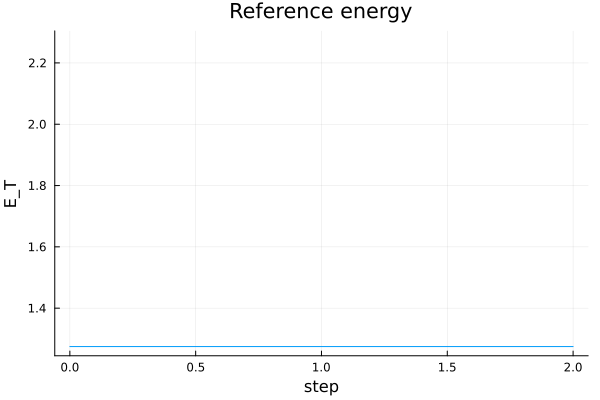

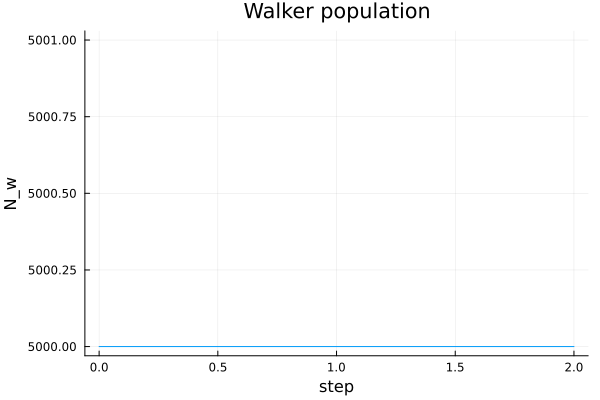

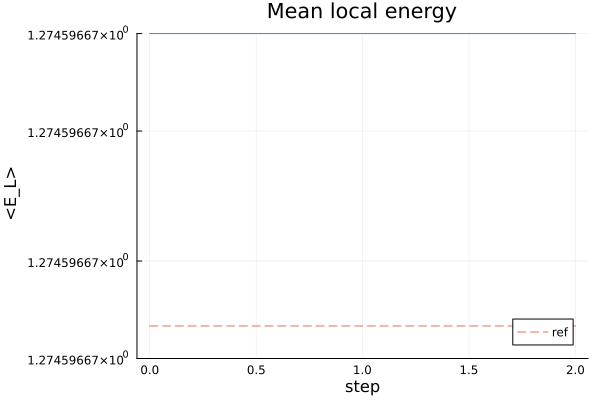

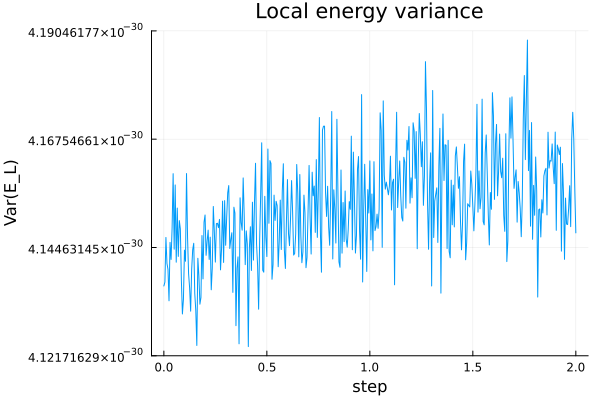

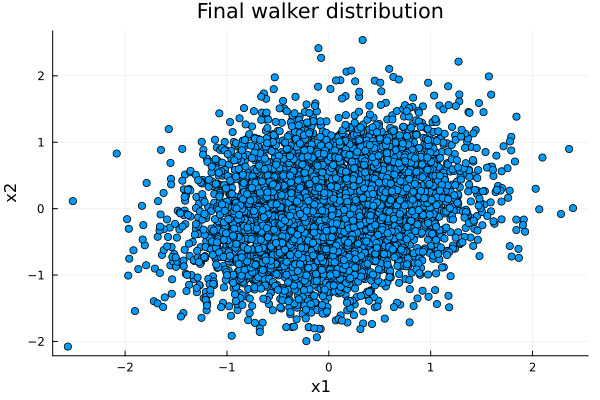

In [3]:
# Results and plots
t = (0:params.nsteps) .* params.dt

nequil = params.nequil
start_idx = min(nequil + 1, length(energy_mean_history))
postE = energy_mean_history[start_idx:end]

Ebar = mean(postE)
SEM = (length(postE) > 1) ? std(postE) / sqrt(length(postE)) : NaN

println(@sprintf("Coupled HO DMC energy (post-eq, nequil=%d): E = %.6f +/- %.6f", nequil, Ebar, SEM))
println(@sprintf("Final step: E = %.6f, Var(E_L) = %.6f", energy_mean_history[end], energy_variance_history[end]))
println(@sprintf("Reference energy: %.6f", E_ref))


Logging.with_logger(Logging.NullLogger()) do
    redirect_stderr(devnull) do
        p1 = plot(t, ET_history, xlabel="step", ylabel="E_T", title="Reference energy", label=false)
        display(p1)
        
        p2 = plot(t, population_history, xlabel="step", ylabel="N_w", title="Walker population", label=false)
        display(p2)
        
        p3 = plot(t, energy_mean_history, xlabel="step", ylabel="<E_L>", title="Mean local energy", label=false)
        plot!(p3, [t[1], t[end]], [E_ref, E_ref], ls=:dash, label="ref")
        display(p3)
        
        p4 = plot(t, energy_variance_history, xlabel="step", ylabel="Var(E_L)", title="Local energy variance", label=false)
        display(p4)
        
        if !isempty(sim.walker_positions_history)
            snap = sim.walker_positions_history[end]
            x1 = [R[1] for R in snap]
            x2 = [R[2] for R in snap]
            p5 = scatter(x1, x2, xlabel="x1", ylabel="x2", title="Final walker distribution", label=false)
            display(p5)
        end
    end
end
